# Imports and setup

In [1]:
import os, glob
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    Resized,
    RandCropByPosNegLabeld,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

%matplotlib inline

print_config()

MONAI version: 0.9.dev2223
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0428f5a29f1fdc577f2c558490266d9db00583e3
MONAI __file__: /home/trojan/anaconda3/envs/monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
root_dir = os.path.join(os.getcwd(), "monai_data_directory")
INPUT_SIZE = (32,32,32)

print(root_dir)

/home/trojan/skia_projects/3D-CT-Artery-Segmentation/monai/monai_data_directory


# Setup transforms for training and validation

In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=INPUT_SIZE,
            pos=1.0,
            neg=0.0,
            num_samples=50,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        #Resized(keys=['image', 'label'], spatial_size=(128,128,64)),
        ToTensord(keys=["image", "label"]),
    ]
)

# Dataset and data loaders

In [4]:
data_dir = '/media/trojan/evo/3D-CT-Artery-Segmentation/data/data_new/data_splitted'

train_images_path = os.path.join(data_dir, 'train/volumes')
train_labels_path = os.path.join(data_dir, 'train/masks')
val_images_path = os.path.join(data_dir, 'val/volumes')
val_labels_path = os.path.join(data_dir, 'val/masks')

train_images_list = sorted(glob.glob(train_images_path + '/*.nii.gz'))
train_labels_list = sorted(glob.glob(train_labels_path + '/*.nii.gz'))
val_images_list = sorted(glob.glob(val_images_path + '/*.nii.gz'))
val_labels_list = sorted(glob.glob(val_labels_path + '/*.nii.gz'))

train_files = [{'image': image_name, 'label': label_name} for image_name,label_name in zip(train_images_list, train_labels_list)]
val_files = [{'image': image_name, 'label': label_name} for image_name,label_name in zip(val_images_list, val_labels_list)]

In [5]:
print(len(train_files))
print(len(val_files))

37
7


In [6]:
# train_ds = Dataset(
#     data=train_files,
#     transform=train_transforms,
# )
# train_loader = DataLoader(
#     train_ds, batch_size=1, shuffle=True, pin_memory=True
# )
# val_ds = Dataset(
#     data=val_files, 
#     transform=val_transforms, 
# )
# val_loader = DataLoader(
#     val_ds, batch_size=1, shuffle=False, pin_memory=True
# )

In [7]:
train_ds = CacheDataset(
    data=train_files,
    transform=train_transforms,
    cache_num=len(train_files),
    #cache_rate=1.0,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, 
    transform=val_transforms, 
    cache_num=len(val_files), 
    #cache_rate=1.0,
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, pin_memory=True
)

Loading dataset: 100%|████████████████████████████| 7/7 [01:06<00:00,  9.48s/it]


image shape: torch.Size([1, 144, 143, 129]), label shape: torch.Size([1, 144, 143, 129])


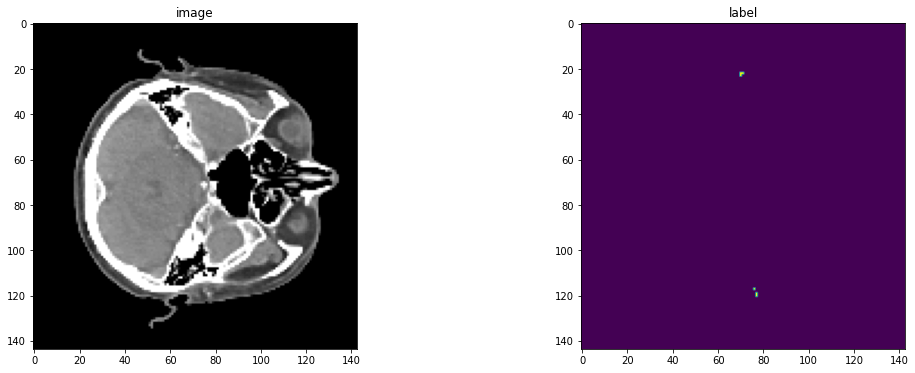

In [8]:
case_num = 1
slice_number = 100

data = val_ds[case_num]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_number].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_number].detach().cpu())
plt.show()

In [9]:
# Check label values
print(np.unique(val_ds[case_num]["label"], return_counts=True))

(array([0., 1., 2.], dtype=float32), array([2655717,     297,     354]))


In [10]:
print(val_ds[case_num]["label"].shape)

torch.Size([1, 144, 143, 129])


# Create model, loss and optimizer

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=INPUT_SIZE,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

ce_weight = torch.tensor([1,1000,1000])
ce_weight = ce_weight.type(torch.cuda.FloatTensor)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, ce_weight=ce_weight)
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

#loss_function = GeneralizedDiceLoss(to_onehot_y=True, softmax=True)

torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
weights_path = os.path.join(root_dir, "best_metric_model.pth")
if os.path.exists(weights_path):
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint)
else:
    print("No checkpoint found.")

# Training process

In [12]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, INPUT_SIZE, 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            mean_dice_val = dice_metric.aggregate().item()
            epoch_iterator_val.set_description(
                "Validation (Dice=%2.5f)" % (mean_dice_val)
            )
        dice_metric.reset()
    return mean_dice_val

In [13]:
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
        
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validation (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [14]:
max_iterations = int(len(train_ds) * 100)
eval_num = len(train_ds)
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (X / X Steps) (loss=X.X):   0%|                 | 0/37 [00:00<?, ?it/s]

No checkpoint found.


/home/trojan/anaconda3/envs/monai/lib/python3.10/site-packages/monai/transforms/utils.py:500: UserWarning: N foreground 0, N  background 709342,unable to generate class balanced samples.
  warnings.warn(
/home/trojan/anaconda3/envs/monai/lib/python3.10/site-packages/monai/transforms/utils.py:500: UserWarning: N foreground 0, N  background 918650,unable to generate class balanced samples.
  warnings.warn(


Training (X / X Steps) (loss=X.X):   0%|                 | 0/37 [00:00<?, ?it/s]

No checkpoint found.


Validation (dice=X.X):   0%|                              | 0/7 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.006425035651773214 Current Avg. Dice: 0.006425035651773214


Training (X / X Steps) (loss=X.X):   0%|                 | 0/37 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                              | 0/7 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.006656794808804989 Current Avg. Dice: 0.006656794808804989


Training (X / X Steps) (loss=X.X):   0%|                 | 0/37 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                              | 0/7 [00:00<?, ?it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.006656794808804989 Current Avg. Dice: 0.006561904214322567


Training (X / X Steps) (loss=X.X):   0%|                 | 0/37 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                              | 0/7 [00:00<?, ?it/s]

Model Was Saved ! Current Best Avg. Dice: 0.006911411881446838 Current Avg. Dice: 0.006911411881446838


Training (X / X Steps) (loss=X.X):   0%|                 | 0/37 [00:00<?, ?it/s]

Validation (dice=X.X):   0%|                              | 0/7 [00:00<?, ?it/s]

RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 302064064 vs 302063952

In [ ]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

In [ ]:
# Plot the loss and metric

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()